In [88]:
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML
import seaborn as sns

In [89]:
def timestr_tosec(timestr):
    timeparts = str.split(timestr,':')
    multipliers = [3600,60,1]
    timesecs = 0
    while len(timeparts) > 0:
        timesecs += int(timeparts.pop()) * multipliers.pop()
    return timesecs

In [90]:
# Load the results file
results = pd.read_csv('./Entries/2024/results.csv',sep=',')
results = results[['Position','Forename','Surname','Off Time','Actual Time']]
results['name'] = results['Forename'] + ' ' + results['Surname']
results['Time_s'] = results['Actual Time'].map(timestr_tosec)
results = results[['Position','name','Off Time','Time_s']]

In [91]:
# Load the predicted results
predictions = pd.read_csv('Entries/2024/predictions2024.csv')
predictions = predictions[['Racer_Name','Season','Race_Name','Predicted Time']]
#merge with results
combined = results.merge(predictions,how='left',left_on='name',right_on='Racer_Name')
combined['error'] = combined['Predicted Time'] - combined['Time_s']
combined

,Position,name,Off Time,Time_s,Racer_Name,Season,Race_Name,Predicted Time,error
0,1,Harriet Wingfield,18:40,1680,Harriet Wingfield,2023.0,PR_Endcliffe,2071.683758,391.683758
1,2,Rob Hale,13:30,2007,Rob Hale,2023.0,PR_Endcliffe,1937.693932,-69.306068
2,3,Dave Camus,18:00,1766,Dave Camus,2023.0,PR_Hillsborough,1835.155750,69.155750
3,4,Chris Basford,18:10,1767,NaN,NaN,NaN,NaN,NaN
4,5,Richard Baybutt,18:30,1761,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
263,83,Hannah Wright,03:00,3397,Hannah Wright,2022.0,PR_Endcliffe,2302.804259,-1094.195741
264,83,Hannah Wright,03:00,3397,Hannah Wright,2022.0,Percy Pud,2583.622016,-813.377984
265,83,Hannah Wright,03:00,3397,Hannah Wright,2023.0,Grindleford,2919.569546,-477.430454
266,83,Hannah Wright,03:00,3397,Hannah Wright,2023.0,PR_Endcliffe,2194.577344,-1202.422656


<Axes: xlabel='error', ylabel='Race_Name'>

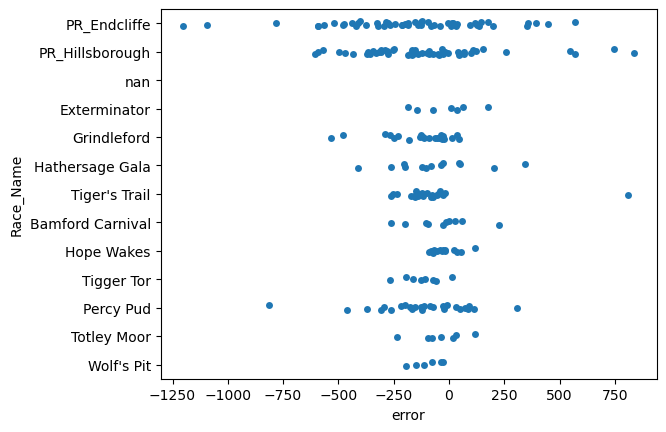

In [92]:
sns.stripplot(combined,y='Race_Name',x='error')

<Axes: xlabel='Time_s', ylabel='error'>

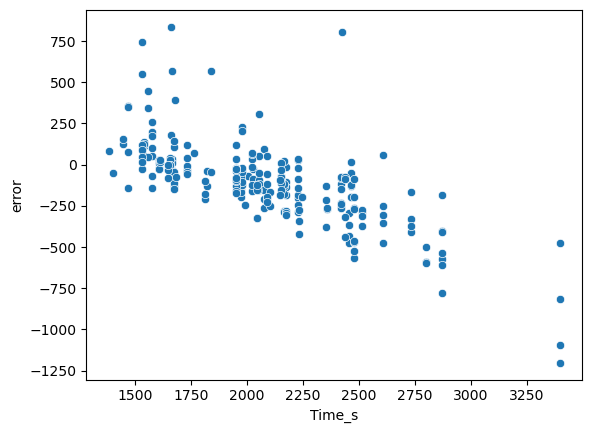

In [93]:
sns.scatterplot(combined,x='Time_s',y='error')

<Axes: ylabel='error'>

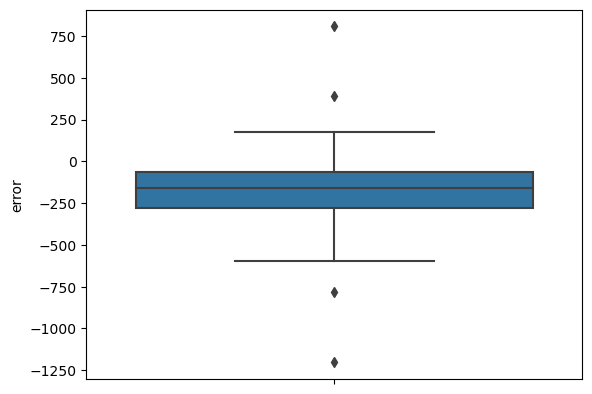

In [94]:
# Choose minimum time strategy
combined_g = combined[['name','Time_s','Predicted Time']]
combined_g = combined_g.groupby('name').min()
combined_g['error'] = combined_g['Predicted Time'] - combined_g['Time_s']
sns.boxplot(combined_g,y='error')


In [113]:
# Choose fastest two times and take average strategy
# Maybe accounts for one of them being poor
combined.sort_values(['Racer_Name','Predicted Time'],inplace=True)
combined['time_rank'] = combined.groupby('Racer_Name')['Predicted Time'].rank('min')
combined12 = combined.loc[combined['time_rank'] <=2]
perf12 = combined12.groupby('Racer_Name',as_index=False)['error'].mean()

<Axes: ylabel='error'>

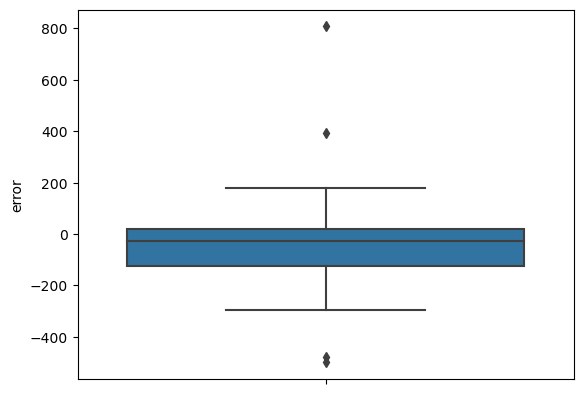

In [96]:
# out of interest, what's the best we could possibly do with the data we had?
combined['error_abs'] = combined['error'].abs()
combined = combined.sort_values(['Racer_Name','error_abs'])
best_errors = combined.groupby('Racer_Name').first()
sns.boxplot(best_errors,y='error')

In [97]:
combined

,Position,name,Off Time,Time_s,Racer_Name,Season,Race_Name,Predicted Time,error,time_rank,error_abs
251,78,Alan Chapman,12:30,2513,Alan Chapman,2023.0,PR_Endcliffe,2236.042257,-276.957743,4.0,276.957743
249,78,Alan Chapman,12:30,2513,Alan Chapman,2022.0,PR_Hillsborough,2223.166080,-289.833920,3.0,289.833920
252,78,Alan Chapman,12:30,2513,Alan Chapman,2023.0,PR_Hillsborough,2204.073709,-308.926291,2.0,308.926291
250,78,Alan Chapman,12:30,2513,Alan Chapman,2022.0,Percy Pud,2140.875877,-372.124123,1.0,372.124123
35,14,Andrew Lewis,09:30,2423,Andrew Lewis,2022.0,Tiger's Trail,3230.454621,807.454621,1.0,807.454621
...,...,...,...,...,...,...,...,...,...,...,...
246,76,John Griffiths,23:10,1840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,79,Derek Brailsford,00:00,3296,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,80,Seb Graham,26:10,1728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,81,Ashlin McAree,21:30,2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='HC_error'>

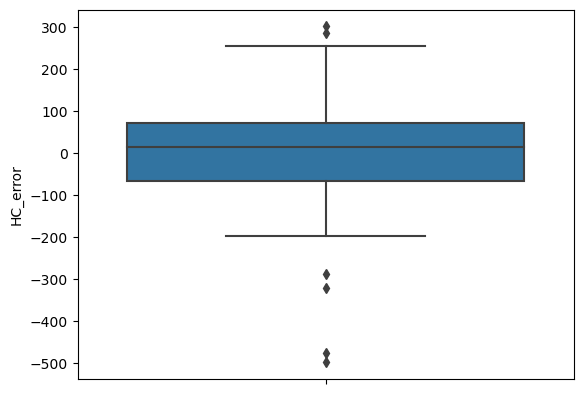

In [109]:
# Analysis of HC results
results['handicap'] = results['Off Time'].apply(timestr_tosec)
results['handicap_c'] = results['handicap'] - results['handicap'].mean()
results['HC_pred'] = results['Time_s'].mean() - results['handicap_c']
results['HC_error'] = results['HC_pred'] - results['Time_s']
sns.boxplot(results,y='HC_error')

<Axes: xlabel='name', ylabel='value'>

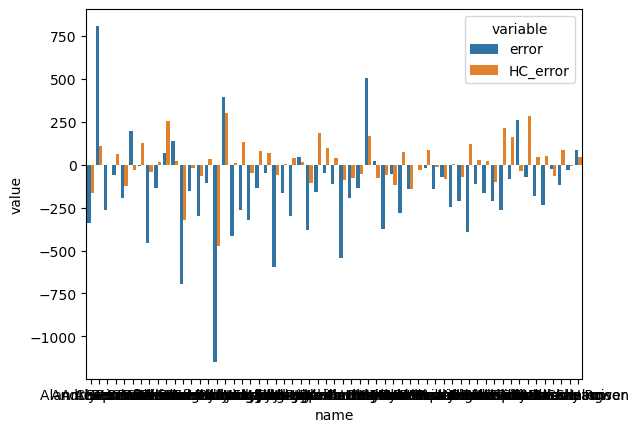

In [122]:
# By runner
byr = perf12.merge(results, left_on='Racer_Name',right_on='name')
byr = byr[['name','error','HC_error']]
byr = byr.melt(id_vars=['name'],value_vars=['error','HC_error'])
sns.barplot(byr,x='name',y='value',hue='variable')
